In [48]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
from imblearn.over_sampling import SMOTE
import gc
import warnings
warnings.filterwarnings('ignore')

In [5]:
# Set random seed for reproducibility
np.random.seed(42)

# 1. Data Collection and Preprocessing

In [108]:
# Define columns to load (select only relevant columns to reduce memory usage)
columns_needed = ['MONTH', 'DAY', 'DAY_OF_WEEK', 'AIRLINE', 'ORIGIN_AIRPORT', 
                 'DESTINATION_AIRPORT', 'SCHEDULED_DEPARTURE', 'DEPARTURE_TIME', 
                 'ARRIVAL_DELAY', 'DISTANCE', 'ARRIVAL_TIME', 'AIR_TIME', 'ELAPSED_TIME',
                 'TAIL_NUMBER', 'DEPARTURE_DELAY', 'TAXI_OUT', 'WHEELS_OFF', 
                 'SCHEDULED_TIME', 'WHEELS_ON', 'TAXI_IN', 'CANCELLATION_REASON', 
                 'AIR_SYSTEM_DELAY', 'SECURITY_DELAY', 'AIRLINE_DELAY', 
                 'LATE_AIRCRAFT_DELAY', 'WEATHER_DELAY']

In [118]:
# Load the dataset with optimized data types to save memory
print("Loading dataset...")
dtype_dict = {
    'MONTH': 'int8', 'DAY': 'int8', 'DAY_OF_WEEK': 'int8',
    'SCHEDULED_DEPARTURE': 'float32', 'DEPARTURE_TIME': 'float32',
    'ARRIVAL_DELAY': 'float32', 'DISTANCE': 'float32',
    'ARRIVAL_TIME': 'float32', 'AIR_TIME': 'float32', 'ELAPSED_TIME': 'float32',
    'DEPARTURE_DELAY': 'float32', 'TAXI_OUT': 'float32', 'WHEELS_OFF': 'float32',
    'SCHEDULED_TIME': 'float32', 'WHEELS_ON': 'float32', 'TAXI_IN': 'float32',
    'AIRLINE': 'category', 'ORIGIN_AIRPORT': 'category', 'DESTINATION_AIRPORT': 'category',
    'TAIL_NUMBER': 'category', 'CANCELLATION_REASON': 'category'
}
df = pd.read_csv(r"C:\Users\SMART TECH\Desktop\AppliedNLPMaterial-master\DataSets\flights.csv", usecols=columns_needed, dtype=dtype_dict)


Loading dataset...


In [119]:
# Sample the dataset to reduce processing time (500,000 rows is manageable)
print("Sampling 500,000 rows to speed up processing...")
df = df.sample(n=500000, random_state=42)


Sampling 500,000 rows to speed up processing...


In [120]:
# Exploratory Data Analysis (EDA)
print("Dataset Shape:", df.shape)
print("\nMissing Values:\n", df.isnull().sum())
print("\nData Types:\n", df.dtypes)

Dataset Shape: (500000, 26)

Missing Values:
 MONTH                       0
DAY                         0
DAY_OF_WEEK                 0
AIRLINE                     0
TAIL_NUMBER              1296
ORIGIN_AIRPORT              0
DESTINATION_AIRPORT         0
SCHEDULED_DEPARTURE         0
DEPARTURE_TIME           7385
DEPARTURE_DELAY          7385
TAXI_OUT                 7667
WHEELS_OFF               7667
SCHEDULED_TIME              0
ELAPSED_TIME             9016
AIR_TIME                 9016
DISTANCE                    0
WHEELS_ON                7965
TAXI_IN                  7965
ARRIVAL_TIME             7965
ARRIVAL_DELAY            9016
CANCELLATION_REASON    492260
AIR_SYSTEM_DELAY       408455
SECURITY_DELAY         408455
AIRLINE_DELAY          408455
LATE_AIRCRAFT_DELAY    408455
WEATHER_DELAY          408455
dtype: int64

Data Types:
 MONTH                      int8
DAY                        int8
DAY_OF_WEEK                int8
AIRLINE                category
TAIL_NUMBER        

In [124]:
# Define delay threshold (arrival delay > 15 minutes)
df['DELAYED'] = (df['ARRIVAL_DELAY'] > 15).astype('int8')
print("\nClass Distribution:\n", df['DELAYED'].value_counts(normalize=True))


Class Distribution:
 DELAYED
0    0.823436
1    0.176564
Name: proportion, dtype: float64


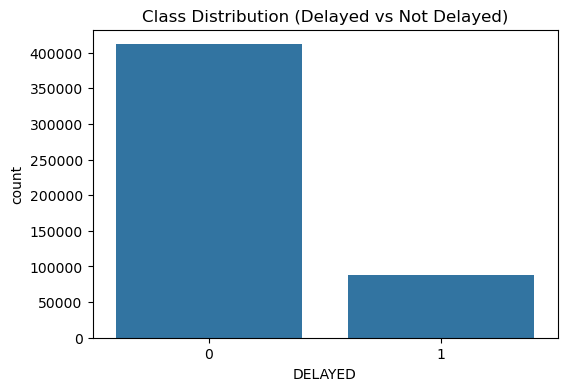

In [104]:
# Visualize class imbalance
plt.figure(figsize=(6, 4))
sns.countplot(x='DELAYED', data=df)
plt.title('Class Distribution (Delayed vs Not Delayed)') 
plt.show()
 

In [126]:
# Step 1: Drop columns with excessive missing values (e.g., > 4.8M missing)
# Comment: These columns (e.g., CANCELLATION_REASON, delay types) have too many missing values 
#          (over 83% missing), so dropping them prevents bias and saves memory.
columns_to_drop = ['CANCELLATION_REASON', 'AIR_SYSTEM_DELAY', 'SECURITY_DELAY', 
                   'AIRLINE_DELAY', 'LATE_AIRCRAFT_DELAY', 'WEATHER_DELAY']
df = df.drop(columns=columns_to_drop)

In [128]:
# Step 2: Impute missing values in numerical columns with median
# Comment: Using median imputation for numerical columns like ARRIVAL_DELAY and DEPARTURE_TIME 
#          because it handles outliers well and keeps the data realistic.
numerical_cols = ['DEPARTURE_TIME', 'ARRIVAL_DELAY', 'DEPARTURE_DELAY', 'TAXI_OUT', 
                  'WHEELS_OFF', 'SCHEDULED_TIME', 'WHEELS_ON', 'TAXI_IN', 'ARRIVAL_TIME', 
                  'AIR_TIME', 'ELAPSED_TIME']
for col in numerical_cols:
    if df[col].isnull().sum() > 0:  # Only impute if there are missing values
        df[col] = df[col].fillna(df[col].median())

In [140]:
# Step 3: Impute missing values in categorical column (TAIL_NUMBER) with 'Unknown'
# Comment: For TAIL_NUMBER, which has 1,296 missing values
df['TAIL_NUMBER'] = df['TAIL_NUMBER'].fillna(df['TAIL_NUMBER'].mode())

In [142]:
# Step 4: Drop any remaining rows with missing values
# Comment: After imputation, drop rows with any remaining missing values to ensure the dataset 
#          is complete for modeling. This is safe since most missing values are already handled.
df = df.dropna()


# Feature Engineering

In [147]:
# Comment: Create new features to capture time of day, season, and distance categories.
def get_time_of_day(time):
    hour = int(time // 100) if pd.notnull(time) else 0  # Handle potential NaN
    if 5 <= hour < 12:
        return 'Morning'
    elif 12 <= hour < 17:
        return 'Afternoon'
    elif 17 <= hour < 22:
        return 'Evening'
    else:
        return 'Night'

df['TIME_OF_DAY'] = df['DEPARTURE_TIME'].apply(get_time_of_day).astype('category')

def get_season(month):
    if month in [12, 1, 2]:
        return 'Winter'
    elif month in [3, 4, 5]:
        return 'Spring'
    elif month in [6, 7, 8]:
        return 'Summer'
    else:
        return 'Fall'

df['SEASON'] = df['MONTH'].apply(get_season).astype('category')

In [149]:
# Comment: Categorize DISTANCE into Short, Medium, and Long to capture non-linear patterns.
df['DISTANCE_CATEGORY'] = pd.cut(df['DISTANCE'], 
                                bins=[0, 500, 1500, float('inf')], 
                                labels=['Short', 'Medium', 'Long']).astype('category')

# Encoding


In [152]:
# Comment: Use LabelEncoder for high-cardinality columns (e.g., airports, airlines) to save memory 
#          by converting categories to integers.
le = LabelEncoder()
high_cardinality_cols = ['AIRLINE', 'ORIGIN_AIRPORT', 'DESTINATION_AIRPORT', 'TAIL_NUMBER']
for col in high_cardinality_cols:
    df[col] = le.fit_transform(df[col].astype(str)).astype('int16')

In [155]:
# Apply one-hot encoding to low-cardinality categorical variables
# Comment: Use one-hot encoding for low-cardinality columns (e.g., TIME_OF_DAY, SEASON) to avoid 
#          ordinal assumptions and improve model performance.
low_cardinality_cols = ['TIME_OF_DAY', 'SEASON', 'DISTANCE_CATEGORY']
df = pd.get_dummies(df, columns=low_cardinality_cols, prefix=low_cardinality_cols, dtype='int8')


In [159]:
# Comment: Combine base features with one-hot encoded columns for modeling.
one_hot_cols = [col for col in df.columns if any(prefix in col for prefix in low_cardinality_cols)]
features = ['MONTH', 'DAY', 'DAY_OF_WEEK', 'AIRLINE', 'ORIGIN_AIRPORT', 
            'DESTINATION_AIRPORT', 'SCHEDULED_DEPARTURE', 'DISTANCE', 'TAIL_NUMBER'] + one_hot_cols
X = df[features]
y = df['DELAYED']
X

,MONTH,DAY,DAY_OF_WEEK,AIRLINE,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_DEPARTURE,DISTANCE,TAIL_NUMBER,TIME_OF_DAY_Afternoon,TIME_OF_DAY_Evening,TIME_OF_DAY_Morning,TIME_OF_DAY_Night,SEASON_Fall,SEASON_Spring,SEASON_Summer,SEASON_Winter,DISTANCE_CATEGORY_Short,DISTANCE_CATEGORY_Medium,DISTANCE_CATEGORY_Long
1508570,4,7,2,4,421,395,1340.0,128.0,3366,1,0,0,0,0,1,0,0,1,0,0
363270,1,24,6,1,477,579,1910.0,867.0,1615,0,1,0,0,0,0,0,1,0,1,0
3003945,7,8,3,13,525,579,630.0,672.0,1776,0,0,1,0,0,0,1,0,0,1,0
2291425,5,26,2,13,597,383,810.0,546.0,3502,0,0,1,0,0,1,0,0,0,1,0
2973084,7,6,1,10,454,443,1000.0,3904.0,571,0,0,1,0,0,0,1,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5372574,12,3,4,13,525,476,620.0,407.0,665,0,0,1,0,0,0,0,1,1,0,0
3913311,8,31,1,0,369,505,1420.0,650.0,3253,1,0,0,0,0,0,1,0,0,1,0
1090370,3,12,4,10,354,387,1837.0,1491.0,1737,0,1,0,0,0,1,0,0,0,1,0
5685306,12,23,3,4,562,453,729.0,1157.0,67,0,0,1,0,0,0,0,1,0,1,0


In [161]:
# Free memory
# Comment: Delete the original DataFrame to free up memory after creating X and y.
del df
gc.collect()

510

### Spliting the Data

In [163]:
# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

### Handle class imbalance with SMOTE (reduced sampling)

In [171]:
smote = SMOTE(sampling_strategy=0.3, random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)
print("\nAfter SMOTE, Class Distribution:\n", pd.Series(y_train_res).value_counts())



After SMOTE, Class Distribution:
 DELAYED
0    328464
1     98539
Name: count, dtype: int64


In [176]:
# Free memory
del X_train, y_train
gc.collect()

0

# 2. Model Development

In [174]:
# Initialize models
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42),
    'Random Forest': RandomForestClassifier(n_estimators=50, random_state=42, n_jobs=-1),
    'XGBoost': XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
}


Training Logistic Regression...


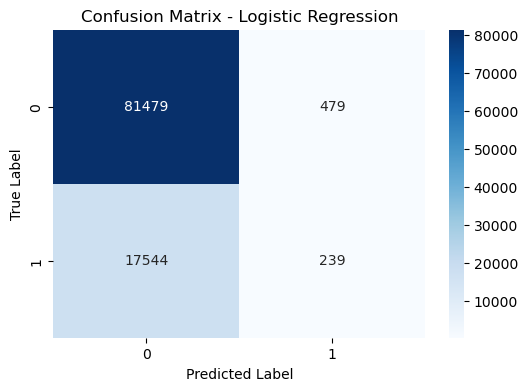


Training Random Forest...


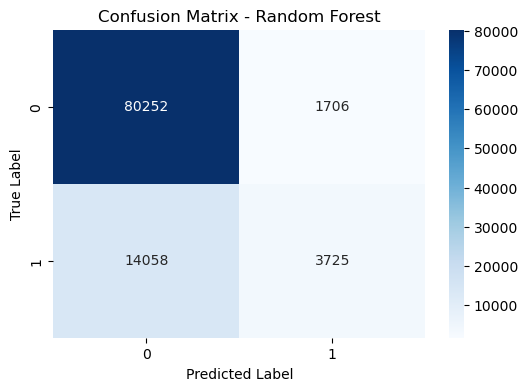


Training XGBoost...


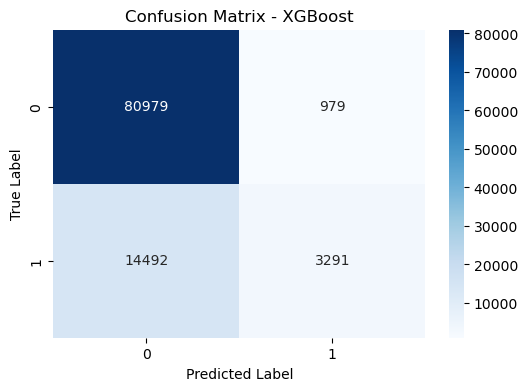

In [178]:
# Train and predict
results = {}
for name, model in models.items():
    print(f"\nTraining {name}...")
    model.fit(X_train_res, y_train_res)
    y_pred = model.predict(X_test)
    
    # Evaluate
    results[name] = {
        'Accuracy': accuracy_score(y_test, y_pred),
        'Precision': precision_score(y_test, y_pred),
        'Recall': recall_score(y_test, y_pred),
        'F1-Score': f1_score(y_test, y_pred),
        'ROC-AUC': roc_auc_score(y_test, y_pred)
    }
    
    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix - {name}')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    # plt.savefig(f'confusion_matrix_{name.lower().replace(" ", "_")}.png')
    plt.show()

# 3. Model Evaluation

In [181]:
# Display results
print("\nModel Performance:")
results_df = pd.DataFrame(results).T
print(results_df)


Model Performance:
                     Accuracy  Precision    Recall  F1-Score   ROC-AUC
Logistic Regression  0.819302   0.332869  0.013440  0.025836  0.503798
Random Forest        0.841951   0.685877  0.209470  0.320927  0.594327
XGBoost              0.844888   0.770726  0.185064  0.298463  0.586560


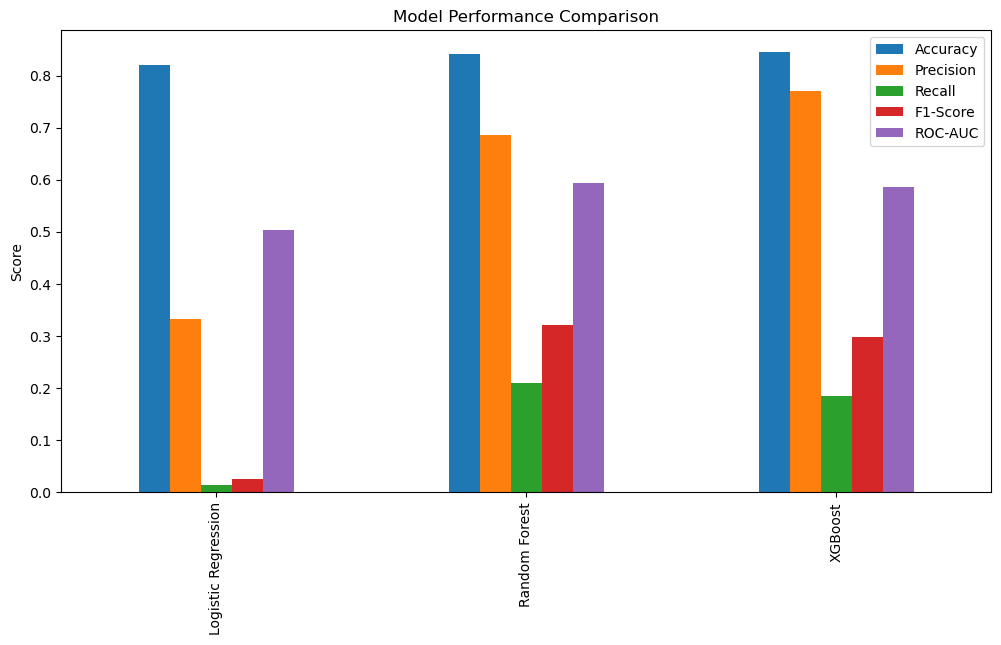

In [185]:
# Visualize performance
results_df.plot(kind='bar', figsize=(12, 6))
plt.title('Model Performance Comparison')
plt.ylabel('Score') 
plt.show()

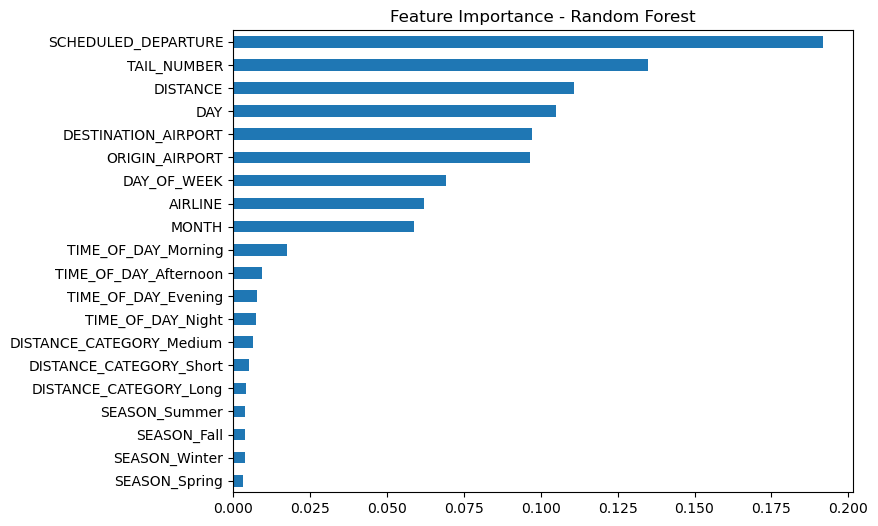

In [189]:
# Feature importance (for Random Forest)
rf = models['Random Forest']
feature_importance = pd.Series(rf.feature_importances_, index=features)
feature_importance.sort_values().plot(kind='barh', figsize=(8, 6))
plt.title('Feature Importance - Random Forest') 
plt.show()

# 4. Model Comparison and Optimization

In [192]:
# Select best model (based on F1-Score)
best_model_name = results_df['F1-Score'].idxmax()
print(f"\nBest Model: {best_model_name}")


Best Model: Random Forest


In [195]:
# Hyperparameter tuning for best model (minimal grid)
if best_model_name == 'Random Forest':
    param_grid = {
        'n_estimators': [50],
        'max_depth': [10],
        'min_samples_split': [2]
    }
    grid_search = GridSearchCV(RandomForestClassifier(random_state=42, n_jobs=-1), 
                              param_grid, 
                              cv=3, 
                              scoring='f1', 
                              n_jobs=-1)
    grid_search.fit(X_train_res, y_train_res)
    print("\nBest Parameters:", grid_search.best_params_)
    
    # Evaluate optimized model
    y_pred_optimized = grid_search.predict(X_test)
    print("\nOptimized Random Forest Performance:")
    print("Accuracy:", accuracy_score(y_test, y_pred_optimized))
    print("Precision:", precision_score(y_test, y_pred_optimized))
    print("Recall:", recall_score(y_test, y_pred_optimized))
    print("F1-Score:", f1_score(y_test, y_pred_optimized))
    print("ROC-AUC:", roc_auc_score(y_test, y_pred_optimized))



Best Parameters: {'max_depth': 10, 'min_samples_split': 2, 'n_estimators': 50}

Optimized Random Forest Performance:
Accuracy: 0.8433242097031312
Precision: 0.8040045121263395
Recall: 0.16032165551369285
F1-Score: 0.2673355525341085
ROC-AUC: 0.5759208511834797
